In [ ]:
# run the header that sets up the environment

already_run = globals().get("already_run", False)
if not (already_run):
    print("Running the header")
    already_run = True
    %run header.ipynb

    load_packages()
    change_wordir()
    colors, colours = colourblind_palette()

m = load_model("latest_dev")
#m = load_model("cyclic_2021")

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling\analyses
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling


# generating data

In [2]:

def pfd_ss_scan(s: object, pfd_values: np.ndarray, y0_loop: dict, debug: bool =False) -> tuple:
    """
    Perform a steady-state scan by varying the parameter "pfd" across different values.

    Returns:
    tuple:
        - DataFrame of steady-state concentrations (rows: pfd values, columns: compound names).
        - DataFrame of steady-state fluxes (rows: pfd values, columns: reaction rates).
    """

    backup_y0 = y0_loop.copy()  # Backup the conditions to reset the system if needed

    fluxes = {}  # store steady-state fluxes for each pfd value
    concentrations = {}  # store steady-state concentrations for each pfd value
    failed_cases = []

    # Iterate over each pfd value with a progress bar
    for x in tqdm(pfd_values, total=len(pfd_values)):  

        s.initialise(y0_loop)  # Reset the system with the given initial conditions
        s.update_parameter("pfd", x)  # Update the parameter "pfd" to the current value
        
        try:
            t, y = s.simulate_to_steady_state()

            if y is None or len(y) == 0:  # Check for invalid output
                raise ValueError(f"Simulation returned empty result at pfd={x}")

            # Store the final steady-state concentrations
            concentrations[x] = s.get_full_results_array()[-1]

            # Store the final steady-state fluxes
            fluxes[x] = s.model.get_fluxes_array(y=y, t=t)[-1]

            # Update initial conditions for the next iteration
            y0_loop = s.get_new_y0()

        except Exception as e:
            logger.warning(f"Simulation failed at pfd={x}: {e}")
            failed_cases.append(x)

            # Store NaNs for failed cases
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            concentrations[x] = np.full(len(all_compounds), np.nan)
            fluxes[x] = np.full(len(rate_names), np.nan)

            # If debug mode is enabled, log additional details
            if debug:
                logger.debug(f"Failed pfd={x}. Initial conditions: {y0_loop}")

    # Log summary after execution
    logger.info(f"Simulation completed. {len(failed_cases)} cases failed: {failed_cases}")

    return (
        pd.DataFrame(concentrations, index=s.model.get_all_compounds()).T,  # Convert concentration results to DataFrame
        pd.DataFrame(fluxes, index=s.model.get_rate_names()).T  # Convert flux results to DataFrame
    )

NUM_SCANS = 100
LOW_LIGHT = 30
HIGH_LIGHT = 1750
PFD_VALUES = np.linspace(LOW_LIGHT, HIGH_LIGHT, NUM_SCANS)

y0 = {
    "PQ": 11.248282037382348,       "PC": 1.3639930534269078,       "Fd": 4.207984023619571,
    "ATP": 1.6085042256522668,      "NADPH": 0.45672250689837696,   "H": 0.002174958602661375,
    "LHC": 0.8079188314632375,      "Psbs": 0.9626375680773129,     "Vx": 0.9570474456930378,
    "PGA": 0.6109221284988471,      "BPGA": 0.0003235574325883373,  "GAP": 0.003190323205250446,
    "DHAP": 0.07018710225866034,    "FBP": 0.0015898274733035427,   "F6P": 0.0886998278393475,
    "G6P": 0.20400960399249862,     "G1P": 0.011832557030606641,    "SBP": 0.003215008299488195,
    "S7P": 0.02811069161049136,     "E4P": 0.003523560381569699,    "X5P": 0.006746131132013272,
    "R5P": 0.011299769265221232,    "RUBP": 0.030373422172205858,   "RU5P": 0.004519907641254276,
    "MDA": 2.2718326276618075e-06,
#    "ASC": 9.999997726884683,
    "H2O2": 1.3296482521160688e-06,
    "DHA": 1.2828228406972059e-09,
#    "GSH": 9.999999998752703,
    "GSSG": 6.236645512101874e-10,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
}

In [3]:
s = Simulator(m)
c_ss_petc, v_ss_petc = pfd_ss_scan(s, PFD_VALUES, y0, True)

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]
2025-03-26 09:28:26,318 - INFO - Simulation completed. 0 cases failed: []


# plotting

In [4]:
def plot_lines(ax, df, labels={"xlab": "no_label", "ylab": "no_label", "title": "no_title"}, **kwargs):
    """Plot multiple lines from a DataFrame with non-overlapping end-point labels."""
    
    # Set axis labels and title
    ax.set_title(labels["title"])
    ax.set_xlabel(labels["xlab"])
    ax.set_ylabel(labels["ylab"])
    
    texts = []  # Store text objects for later adjustment

    # Plot each column separately with labels
    for col_name in df.columns:
        x_data = df.index
        y_data = df[col_name]

        # Avoid plotting entirely NaN columns
        if np.isnan(y_data).all():
            continue
        
        # Plot line
        ax.plot(x_data, y_data, label=col_name)
        
        # Get last valid point
        last_idx = np.where(~np.isnan(y_data))[0][-1]  
        x_last, y_last = x_data[last_idx], y_data.iloc[last_idx]

        # Create text label at last data point
        texts.append(ax.text(x_last, y_last, col_name, fontsize=10, va='center', ha='left'))

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Adjust text positions to avoid overlaps
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

    return ax

### compounds

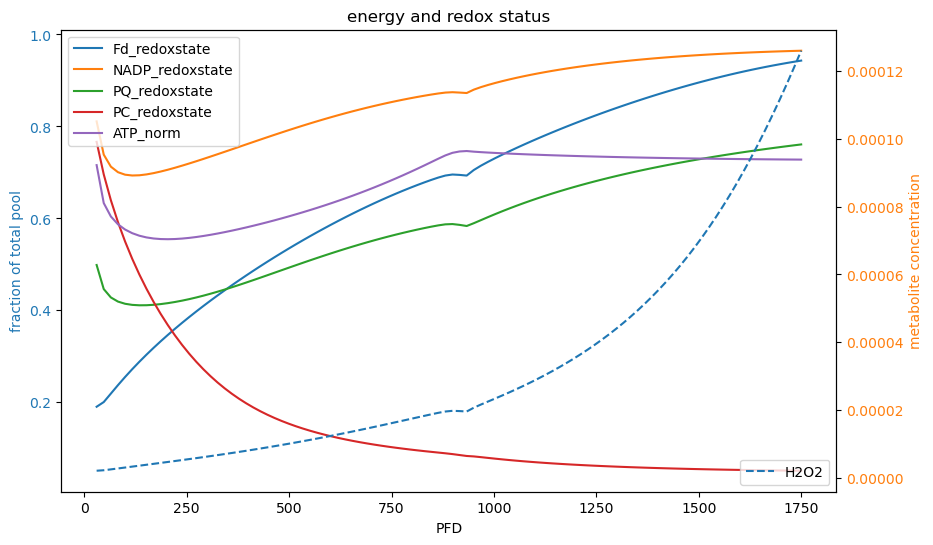

In [5]:
# ELECTRON CARRIERS

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

ax1 = c_ss_petc.loc[:,["Fd_redoxstate",
                "NADP_redoxstate",
                "PQ_redoxstate",
                "PC_redoxstate",
                "ATP_norm"
                ]].plot(ax = ax1,
                        title="energy and redox status",
                        xlabel="PFD",
                        ylabel="fraction of total pool",
                        figsize=(10, 6))

ax2 = ax1.twinx()

ax2 = c_ss_petc.loc[:,["H2O2"]].plot(ax = ax2, linestyle = "--")

ax2.set_ylabel("metabolite concentration", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.set_ylabel("fraction of total pool", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')


In [6]:
folder = "figures/new_model/steady_state_dynamics/"
name = f"energy_and_redox_status"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")
plt.close(fig)

<Axes: title={'center': 'redox states of PSI'}, xlabel='PFD', ylabel='fraction of total pool'>

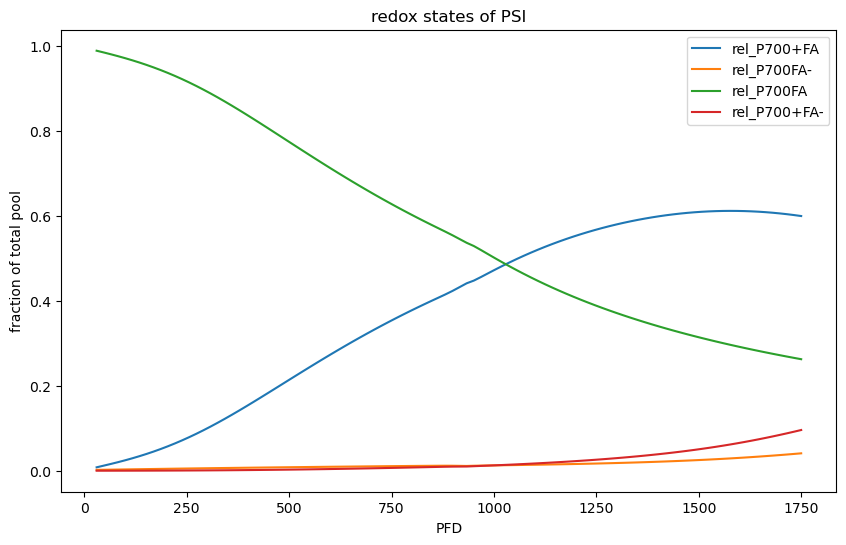

In [7]:
# PSI REDOX STATES

# df = c_ss_petc.loc[:,["rel_P700+FA",
#                 "rel_P700FA-",
#                 "rel_P700FA",
#                 "rel_P700+FA-"
# ]]
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# plot_lines(ax, df, labels={"xlab": "PFD", "ylab": "fraction of total pool", "title": "redox states of PSI"})

fig, ax1 = plt.subplots(1, 1, figsize=(10, 2))

c_ss_petc.loc[:,["rel_P700+FA",
                "rel_P700FA-",
                "rel_P700FA",
                "rel_P700+FA-"
                ]].plot(ax=ax1,
                        title="redox states of PSI",
                        xlabel="PFD",
                        ylabel="fraction of total pool",
                        #logy=True,
                        figsize=(10, 6))

In [8]:
folder = "figures/new_model/steady_state_dynamics/"
name = f"PSI_redox_states"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")
plt.close(fig)

### fluxes

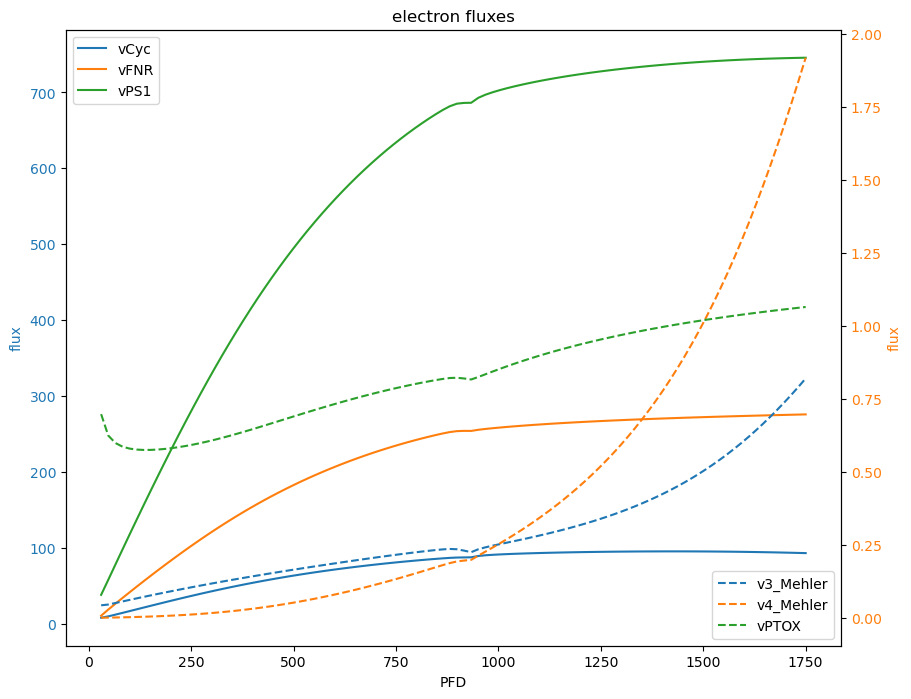

In [9]:
# ELECTRON FLUXES

# ax = v_ss_petc.loc[:,["vCyc",
#                 "vFNR",
#                 "vPS1",
#                 "v3_Mehler",
#                 "v4_Mehler",
#                 "vPTOX"
#                 ]].plot(title="electron fluxes",
#                         xlabel="PFD",
#                         ylabel="flux",
#                         figsize=(10, 6))

#ax.set_yscale('log')



fig, ax1 = plt.subplots(figsize=(10, 8))

# Plot the first set of data on ax1 (left y-axis)
v_ss_petc.loc[:, ["vCyc", "vFNR", "vPS1"]].plot(ax=ax1, title="electron fluxes", xlabel="PFD", ylabel="flux")

# Create a second y-axis (right y-axis)
ax2 = ax1.twinx()

# Plot the second set of data on ax2 (right y-axis)
v_ss_petc.loc[:, ["v3_Mehler", "v4_Mehler", "vPTOX"]].plot(ax=ax2, linestyle="--")  # Change linestyle as needed

# Set the y-axis label for the second axis
ax2.set_ylabel("flux", color='tab:orange')

# Optionally, set different colors for the axes to distinguish them
ax1.set_ylabel("flux", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.show()


In [10]:
folder = "figures/new_model/steady_state_dynamics/"
name = f"electron_flows"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

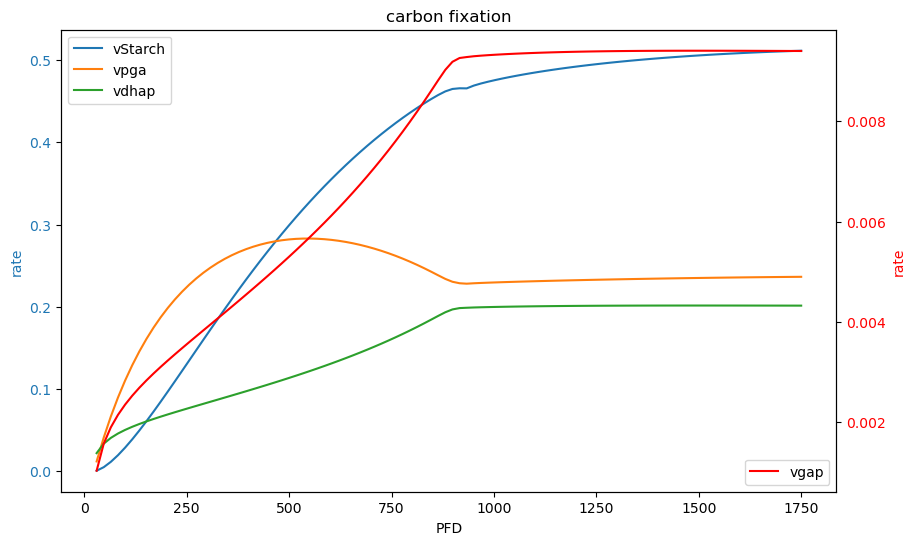

In [11]:
# CARBON FIXATION

# df = v_ss_petc.loc[:,["vStarch",
#                 "vpga",
#                 "vgap",
#                 "vdhap"
# ]]

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# plot_lines(ax, df, labels={"xlab": "PFD", "ylab": "rate", "title": "carbon fixation"})

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

v_ss_petc.loc[:,["vStarch",
                "vpga",
                "vdhap"
                ]].plot(ax = ax1,
                        title="carbon fixation",
                        xlabel="PFD",
                        ylabel="rate",
                        figsize=(10, 6))

ax2 = ax1.twinx()

ax2 = v_ss_petc.loc[:,["vgap"]].plot(ax = ax2, color = "red")

ax2.set_ylabel("rate", color='red')

# Optionally, set different colors for the axes to distinguish them
ax1.set_ylabel("rate", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')


plt.show()

In [12]:
folder = "figures/new_model/steady_state_dynamics/"
name = f"carbon_fixation_fluxes"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")
plt.close(fig)

<Axes: title={'center': 'state fluxes of PSI'}, xlabel='PFD', ylabel='flux'>

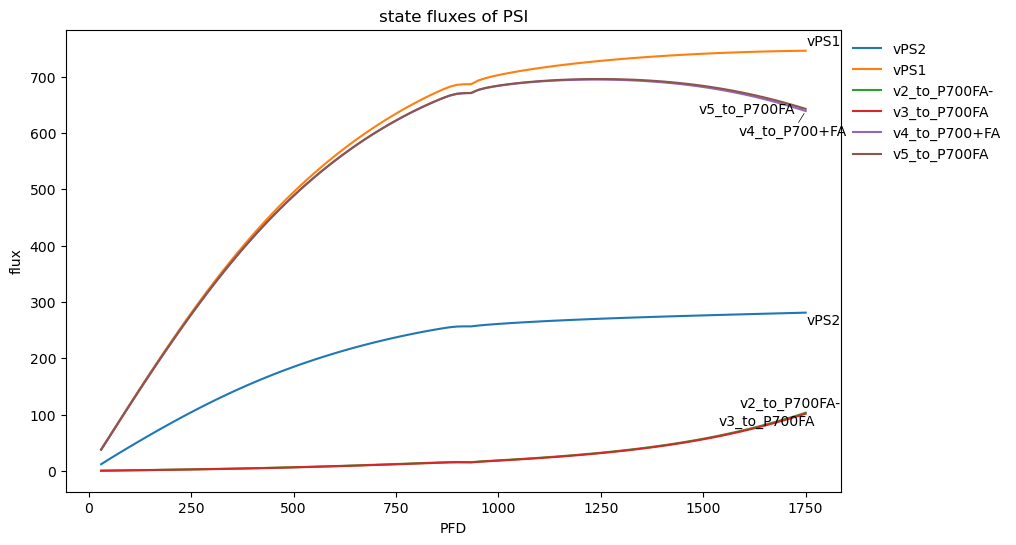

In [13]:
# PHOTOSYSTEM RATES

df = v_ss_petc.loc[:,["vPS2",
                "vPS1",
                "v2_to_P700FA-",
                "v3_to_P700FA",
                "v4_to_P700+FA",
                "v5_to_P700FA"
]]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_lines(ax, df, labels={"xlab": "PFD", "ylab": "flux", "title": "state fluxes of PSI"})

# v_ss_petc.loc[:,["vPS2",
#                 "vPS1",
#                 "vMehler",
#                 "v2_to_P700FA-",
#                 "v3_to_P700FA",
#                 "v4_to_P700+FA",
#                 "v5_to_P700FA"
#                 ]].plot(title="redox states of PSI",
#                         xlabel="PFD",
#                         ylabel="fraction of total pool",
#                         #logy=True,
#                         figsize=(10, 6))
# plt.show()

In [14]:
folder = "figures/new_model/steady_state_dynamics/"
name = f"PSI_state_fluxes"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")
plt.close(fig)